
# Test Script

Testing the forward simulation functions and the layered inversion functions using a very simple 1D model.


## Import Modules




In [11]:
import numpy as np

from matplotlib import pyplot as plt
from discretize import TensorMesh
from simpeg.utils import plot_1d_layer_model

from simpeg import (
    data,
    maps
)
from layered_inversion import LayeredInversion
from forward_freq_survey import Forward_Freq_Survey

## Create Survey




In [3]:
# Frequencies being observed in Hz
frequencies = np.array([382, 1822, 7970, 35920, 130100], dtype=float)
z0 = 30
moment = 1
coil_spacing = 10
sim = Forward_Freq_Survey(frequencies, z0, moment, coil_spacing)

## Defining a 1D Layered Earth Model




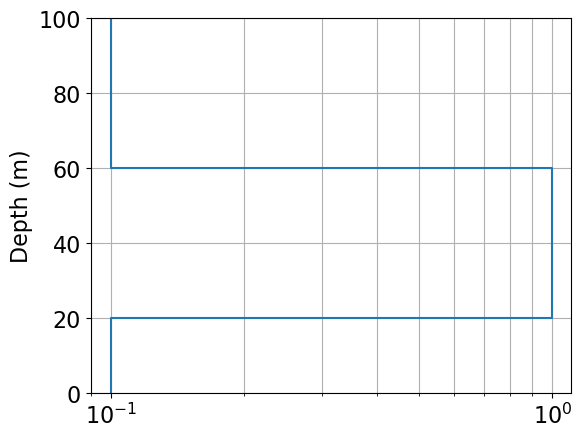

In [15]:
# Physical properties
background_conductivity = 1e-1
layer_conductivity = 1e0

# Layer thicknesses
thicknesses = np.array([20.0, 40.0])
n_layer = len(thicknesses) + 1

# physical property model (conductivity model)
model = background_conductivity * np.ones(n_layer)
model[1] = layer_conductivity

# Define a mapping from model parameters to conductivities
model_mapping = maps.IdentityMap(nP=n_layer)

# Plot conductivity model
thicknesses_for_plotting = np.r_[thicknesses, 40.0]
mesh_for_plotting = TensorMesh([thicknesses_for_plotting])

fig = plt.figure(figsize=(6, 5))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
plot_1d_layer_model(thicknesses_for_plotting, model, ax=ax, show_layers=False)
ax.grid(which="both")
plt.gca().invert_yaxis()

## Define the Forward Simulation, Predict Data and Plot


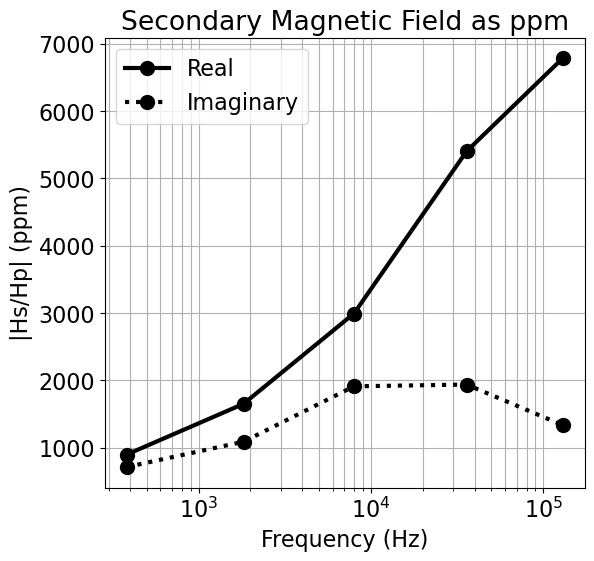

In [16]:
# Predict sounding data
dpred = sim.predict_data(thicknesses, model)

# Plot sounding data
fig = plt.figure(figsize=(6, 6))
ax = fig.add_axes([0.15, 0.15, 0.8, 0.75])
ax.semilogx(frequencies, np.abs(dpred[0::2]), "k-o", lw=3, ms=10)
ax.semilogx(frequencies, np.abs(dpred[1::2]), "k:o", lw=3, ms=10)
ax.set_xlabel("Frequency (Hz)")
ax.set_ylabel("|Hs/Hp| (ppm)")
ax.set_title("Secondary Magnetic Field as ppm")
ax.grid(which='both')
ax.legend(["Real", "Imaginary"])

In [17]:
# Add in artificial noise
noise = 0.05 * np.abs(dpred) * np.random.randn(len(dpred))
dobs = dpred + noise

## Perform Inversion

In [ ]:
uncertainties = 0.05 * np.abs(dobs) * np.ones(np.shape(dobs))

# Define the data object
data_object = data.Data(sim.survey, dobs=dobs, noise_floor=uncertainties)

# Initialize LayeredInversion with current data_object and simulation parameters
layered_inversion = LayeredInversion(
        data_object=data_object, 
        survey=sim.survey, 
        soil_conductivity=background_conductivity,
        beta0_ratio=5.0,
        coolingFactor=2.0, 
        coolingRate=3.0,
        depth_min = 0.5,  # top layer thickness
        depth_max = 200.0,  # depth to lowest layer
        geometric_factor = 1.1  # rate of thickness increase
)
# Run the inversion and store the recovered model
recovered_L2model = layered_inversion.run_inversion()


Running inversion with SimPEG v0.22.2

                        simpeg.InvProblem is setting bfgsH0 to the inverse of the eval2Deriv.
                        ***Done using same Solver, and solver_opts as the Simulation1DLayered problem***
                        
model has any nan: 0
============================ Inexact Gauss Newton ============================
  #     beta     phi_d     phi_m       f      |proj(x-g)-x|  LS    Comment   
-----------------------------------------------------------------------------
x0 has any nan: 0
   0  1.27e+00  3.16e+02  0.00e+00  3.16e+02    6.99e+01      0              
   1  1.27e+00  9.82e+01  4.99e+01  1.62e+02    2.32e+01      0              
   2  1.27e+00  6.20e+01  6.46e+01  1.44e+02    9.84e+00      0   Skip BFGS  
   3  6.37e-01  5.23e+01  6.98e+01  9.68e+01    2.41e+01      0   Skip BFGS  
   4  6.37e-01  2.06e+01  1.01e+02  8.50e+01    4.45e+00      0              
   5  6.37e-01  1.86e+01  1.03e+02  8.41e+01    2.13e+00      0   Skip B

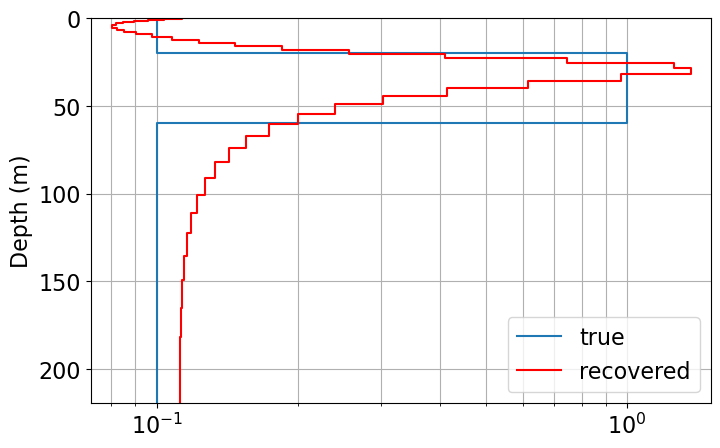

In [20]:
fig, ax1 = plt.subplots(1, 1, figsize=(8, 5))
plot_1d_layer_model(thicknesses_for_plotting, model, ax=ax1, show_layers=False)
plot_1d_layer_model(layered_inversion.layer_thicknesses, 
                    layered_inversion.log_conductivity_map * recovered_L2model, 
                    scale="log", 
                    color="r", 
                    ax=ax1)
ax1.grid(which="both")
ax1.legend(["true", "recovered"])
plt.show()